# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 

sns.set_style("darkgrid")

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

/Users/burmashev/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California h

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.188507028885

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    predicts = np.zeros((num_runs, y.shape[0])) # num_runs массивов, в каждом будет лежать i-й предикшн
    predicts[:] = np.nan # https://stackoverflow.com/questions/1704823/create-numpy-matrix-filled-with-nans
    for i in range(num_runs):
        bootstrap_mask = np.random.randint(X.shape[0], size=X.shape[0]) # маска элементов из текущего бутстрепа
        oob_mask = np.setdiff1d(np.arange(X.shape[0]), bootstrap_mask) # all - bootstrap, https://stackoverflow.com/questions/25330959/how-to-select-inverse-of-indexes-of-a-numpy-array
        
        model = regressor.fit(X[bootstrap_mask], y[bootstrap_mask])
        y_pred = model.predict(X[oob_mask])
        predicts[i][oob_mask] = y_pred # кладу i-й предикшн, все элементы по индексам ~out-of-bag будут нанами
        
        
    '''
    Из-за использования бутстрапа мы каждый раз считаем предикты для разных подмножеств наших объектов,
    следовательно часть ячеек, не попавших в выборку, останется нанами из predicts[:] = np.nan, 
    чтобы их не учитывать и не получить в результате взятия mean nan я использую np.nanmean
    '''
    
    avg_predicts = np.nanmean(predicts, axis=0)
    bias = np.square(avg_predicts - y) # квадрат разности среднего предсказания и правильного ответа
    variance = np.square(predicts - avg_predicts) # дисперсия предсказаний 
    error = np.square(predicts - y) # квадраты разности предсказания и правильного ответа
    return np.mean(bias), np.nanmean(variance), np.nanmean(error)

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

lr = LinearRegression()
dct = DecisionTreeRegressor()
rfr = RandomForestRegressor()

for model, name in [(lr, 'Linear Regression'), (dct, 'Decision Tree'), (rfr, 'Random Forest')]:
    print(f'{name}:')
    bias, variance, error = compute_biase_variance(model, X, y)
    print(f'bias: {bias}, variance: {variance}, error: {error}')

Linear Regression:
bias: 23.692605527275827, variance: 0.9153860031271033, error: 24.53306507258799
Decision Tree:
bias: 10.22524749910937, variance: 13.1532540937091, error: 23.49902440729745
Random Forest:
bias: 10.652735549643586, variance: 2.2353859790219297, error: 12.87729881223317


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ из 9й лекции знаем:

> Как правило, смещение маленькое у сложных семейств (например,
у деревьев) и большое у простых семейств (например, линейных классификаторов).

> Как правило, простые семейства имеют маленькую дисперсию,
а сложные семейства - большую дисперсию.

Результаты:

* у линейной регрессии большое (24) смещение и маленький (0.9) разброс
* у DCT смещение меньше (10 vs 23), но разброс при этом сильно больше (13 vs 0.9)
* у случайного леса смещение маленькое аналогично DCT, а вот разброс сильно меньше, чем у DCT (2 vs 13)

Линейная регрессия не так хорошо приближает оптимальный алгоритм (большое смещение), зато она не подвержена сильному переобучению (низкий разброс). Решающее дерево может показывать лучшие результаты (маленькое смещение), но у него большой риск переобучиться (большой разброс). Случайный лес обладает аналогичным решающему дереву смещением, зато получает маленький разброс за счет того что это композиция решающих деревьев, по итогу наименьшая ошибка получилась как раз у случайного леса

Итог: результаты полностью согласуются с тем, что мы обсуждали на занятиях

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ из той же самой 9 лекции:
> Бэггинг не ухудшает смещенность модели.

> Если базовые алгоритмы некоррелированы,
то дисперсия композиции в $N$ раз меньше дисперсии отдельных алгоритмов.
Если же корреляция имеет место, то уменьшение дисперсии может быть гораздо
менее существенным. [$N$ - количество базовых алгоритмов]

В $BaggingRegressor$ по умолчанию $N = 10$, но мы видим, что разброс не уменьшается в 10 раз, поскольку у нас явно есть корелляция и мы находимся не в сферическом вакууме теории

In [9]:
from sklearn.ensemble import BaggingRegressor

'''
n_estimators = 10
'''
b_lr = BaggingRegressor(lr)
b_dct = BaggingRegressor(dct)
b_rfr = BaggingRegressor(rfr)

for model, name in [(b_lr, 'Linear Regression'), (b_dct, 'Decision Tree'), (b_rfr, 'Random Forest')]:
    print(f'{name}:')
    bias, variance, error = compute_biase_variance(model, X, y)
    print(f'bias: {bias}, variance: {variance}, error: {error}')

Linear Regression:
bias: 23.71154707543759, variance: 0.9942888396052926, error: 24.580749856919457
Decision Tree:
bias: 10.654976021178244, variance: 3.39170541096338, error: 14.050903982590945
Random Forest:
bias: 11.632931167232245, variance: 1.4045312886486352, error: 13.129007620071205


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
from sklearn.model_selection import train_test_split

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    plt.title(title)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)
    for i in range(num_runs):
        bootstrap_mask = np.random.randint(X_train.shape[0], size=X_train.shape[0]) 
        model = regressor.fit(X_train[bootstrap_mask], y_train[bootstrap_mask])
        y_pred = model.predict(X_test)
        plt.scatter(np.arange(num_test_objects), y_pred, c='orange')
    
    plt.scatter(np.arange(num_test_objects), y_test, c='black')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

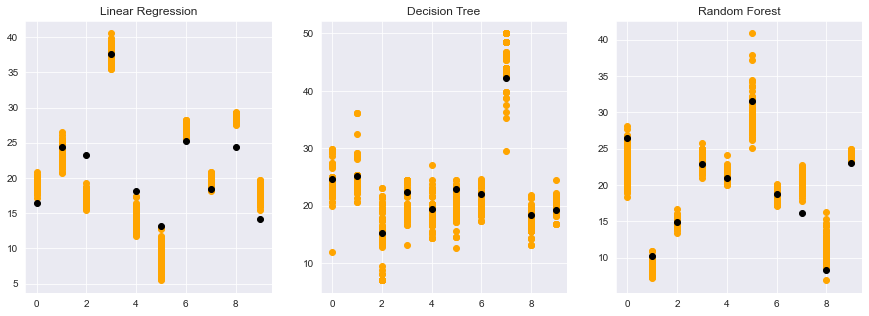

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plot_predictions(lr, X, y, title='Linear Regression')

plt.subplot(1, 3, 2)
plot_predictions(dct, X, y, title='Decision Tree')

plt.subplot(1, 3, 3)
plot_predictions(rfr, X, y, title='Random Forest')

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

* линейная регрессия: все предсказания для каждого объекта находятся достаточно близко друг к другу (маленький разброс), но далеко не всегда предсказания находятся близко к y_test (большое смещение)

* решающее дерево: есть выбросы (отдельные оранжевые точки) в предсказаниях, предсказания сильнее разбросаны по графику (большой разброс), при этом в среднем предсказания попадают близко к y_test (маленькое смещение)

* случайный лес: также предсказания попадают близко к y_test (маленькое смещение), при этом выбросов стало сильно меньше и разброс соотвественно уменьшился (маленький разброс)

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

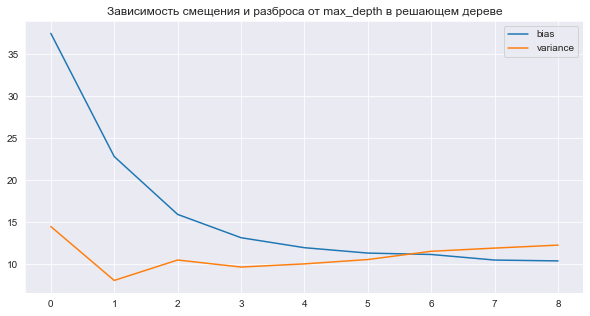

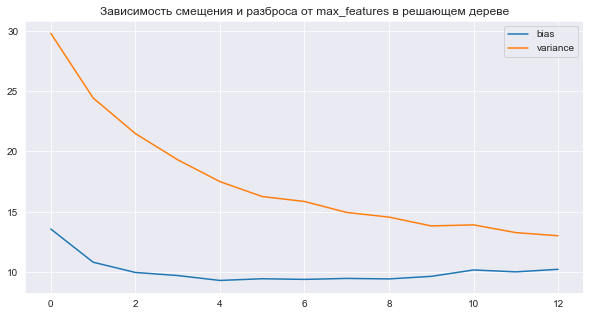

In [12]:
depth_metrics = {
    'bias': [],
    'variance': [],
}

features_metrics = {
    'bias': [],
    'variance': [],
}

for depth in range(1, 10):
    dct = DecisionTreeRegressor(max_depth=depth)
    bias, variance, _ = compute_biase_variance(dct, X, y) 
    depth_metrics['bias'].append(bias)
    depth_metrics['variance'].append(variance)
    
for features in range(1, X.shape[1] + 1):
    dct = DecisionTreeRegressor(max_features=features)
    bias, variance, _ = compute_biase_variance(dct, X, y) 
    features_metrics['bias'].append(bias)
    features_metrics['variance'].append(variance)


for metrics, name in [(depth_metrics, 'max_depth'), (features_metrics, 'max_features')]:
    plt.figure(figsize=(10, 5))
    plt.title(f'Зависимость смещения и разброса от {name} в решающем дереве')
    plt.plot(metrics['bias'], label='bias')
    plt.plot(metrics['variance'], label='variance')
    plt.legend()
    plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

2 ready
4 ready
8 ready
16 ready
32 ready
64 ready
128 ready
256 ready
512 ready


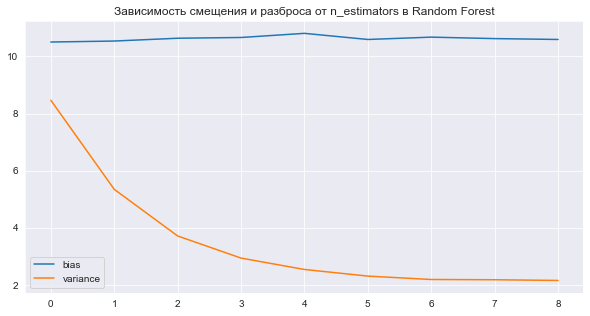

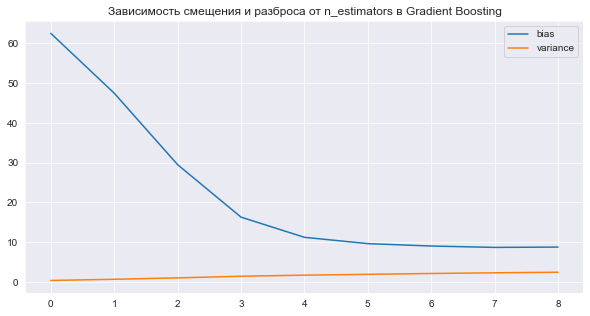

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

rfr_metrics = {
    'bias': [],
    'variance': [],
}

gbr_metrics = {
    'bias': [],
    'variance': [],
}

for n_estimators_ in 2 ** (np.arange(1, 10)):
    rfr = RandomForestRegressor(n_estimators=n_estimators_)
    gbr = GradientBoostingRegressor(n_estimators=n_estimators_)
    
    bias, variance, _ = compute_biase_variance(rfr, X, y) 
    rfr_metrics['bias'].append(bias)
    rfr_metrics['variance'].append(variance)
    
    bias, variance, _ = compute_biase_variance(gbr, X, y) 
    gbr_metrics['bias'].append(bias)
    gbr_metrics['variance'].append(variance)
    print(f'{n_estimators_} ready')

for metrics, name in [(rfr_metrics, 'Random Forest'), (gbr_metrics, 'Gradient Boosting')]:
    plt.figure(figsize=(10, 5))
    plt.title(f'Зависимость смещения и разброса от n_estimators в {name}')
    plt.plot(metrics['bias'], label='bias')
    plt.plot(metrics['variance'], label='variance')
    plt.legend()
    plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__


1. С увеличением параметра max_depth дерево становится более сложным, смещение уменьшается, разброс увеличивается, все как на лекциях рассказывали

2. С увеличением параметра max_features смещение почти что не меняется, а вот разброс уменьшается, вероятно при малых max_features дереву просто недостаточно информации чтобы обучиться хорошо, а когда информации становится достаточно оно начинает работать как надо (работать лучше)

3. Поведение аналогичное пункту 4 выше. Смещение особо не меняется с изменением параметра n_estimators (как рассказывали на лекции), разброс уменьшается (конечно не в n_estimators раз, но уменьшается)

4. С увеличением числа n_estimators смещение уменьшается, поскольку модель усложняется, но на определенном этапе выходит на плато и больше особо не меняется, а разброс соответственно наоборот потихоньку увеличивается. 

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__


![1](cat1.jpg)

![2](cat2.jpg)